In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
cd /content/gdrive/MyDrive/Colab Notebooks/hy24_bigdata/0320 강의/

In [3]:
import pandas as pd
from glob import glob

국토교통부 실거래가 조회 > 실거래가 자료 제공

https://rt.molit.go.kr/

In [ ]:
flist = glob('data/*.csv')
print (flist)

In [5]:
data = pd.read_csv(flist[0], sep=",", encoding="cp949", skiprows=15, dtype="str")

In [6]:
for file in flist[1:]:
  data = pd.concat([data, pd.read_csv(file, sep=",", encoding="cp949", skiprows=15, dtype="str")], axis=0)

In [ ]:
data

In [7]:
data['해제사유발생일'].fillna('', inplace=True)

In [8]:
data = data[data['번지'].str[0].isin(['0','1','2','3','4','5','6','7','8','9'])]

In [9]:
data = data[~data['건축년도'].isnull()]

법정동코드 목록 조회 행정표준

https://www.code.go.kr/stdcode/regCodeL.do

In [ ]:
법정동코드 = pd.read_csv('법정동코드/법정동코드 전체자료.txt', sep='\t', encoding='cp949', dtype='str')
법정동코드.shape

In [ ]:
법정동코드

In [15]:
법정동코드 = 법정동코드[법정동코드['폐지여부']=='존재']

In [16]:
data_code = data.merge(법정동코드, how='left', left_on='시군구', right_on='법정동명')

In [ ]:
data_code

In [ ]:
법정동코드[법정동코드['법정동명'].str.contains('고양시 덕양구')]

In [19]:
data_code = data_code[~data_code['법정동코드'].isnull()]

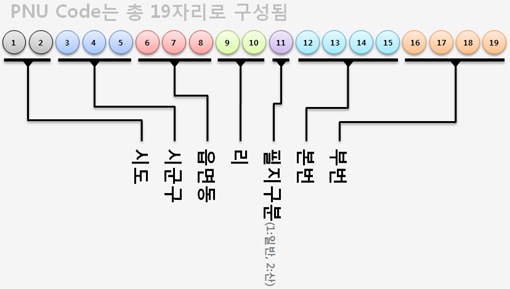

In [20]:
data_code['PNU'] = data_code['법정동코드'] + '1' + data_code['본번'] + data_code['부번']

In [ ]:
data_code

건축물대장 민간 개방 시스템

https://open.eais.go.kr/

In [22]:
cols = pd.read_excel('건축물/데이터구조.xls', skiprows=1)
cols.shape

(64, 3)

In [ ]:
cols

In [ ]:
cols['컬럼 한글명'].values

In [ ]:
building = pd.read_csv('건축물/mart_djy_02.txt', sep='|', encoding='cp949', names=cols['컬럼 한글명'].values, dtype='str')
building.shape

In [ ]:
building[['시군구_코드', '법정동_코드', '대지_구분_코드', '번', '지', '특수지_명', '블록', '로트']]

In [28]:
building[['특수지_명', '블록', '로트']] = building[['특수지_명', '블록', '로트']].fillna('')

In [29]:
building = building[building['특수지_명']=='']
building = building[building['블록']=='']
building = building[building['로트']=='']

In [ ]:
building[['시군구_코드', '법정동_코드', '대지_구분_코드', '번', '지', '특수지_명', '블록', '로트']]

In [ ]:
building['대지_구분_코드'].value_counts()

In [32]:
building = building[building['대지_구분_코드']=='0']

In [33]:
building['PNU'] = building['시군구_코드'] + building['법정동_코드'] + '1' + building['번'] + building['지']

In [ ]:
building['PNU'].value_counts()

In [35]:
building = building.drop_duplicates('PNU', keep='first')

In [36]:
data_code_bld = data_code.merge(building, how='left', left_on='PNU', right_on='PNU')

In [ ]:
data_code_bld[data_code_bld['시군구'].str.contains('서울특별시')]

In [ ]:
data_code_bld.columns

In [ ]:
!pip install geopandas

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt

국가 공간 정보 중점 데이터 > 연속지적도 > shp

http://openapi.nsdi.go.kr/nsdi/index.do

In [43]:
지적도 = gpd.read_file('연속지적/지적도축소.shp', dtype='str', encoding='cp949')

In [ ]:
지적도.head(10)

In [45]:
지적도_축소 = 지적도[지적도['A1'].isin(data_code_bld['PNU'])]


In [46]:
지적도_축소.to_file('지적도축소.shp', encoding='cp949')

In [47]:
data_geo = 지적도_축소.merge(data_code_bld, how='right', left_on='A1', right_on='PNU')

In [ ]:
data_geo.columns

In [ ]:
plt.figure(figsize=(10,10))
data_geo[data_geo["시군구"]=="서울특별시 강남구 역삼동"].plot(cmap="Reds", column="거래금액(만원)")

In [ ]:
data_geo[data_geo["시군구"]=="서울특별시 강남구 역삼동"][data_geo.columns.values[10:]]